In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [23]:
data = pd.read_csv('https://aaa-pgdmlai.s3.amazonaws.com/logistic_member_prob.csv')
data = data.dropna()
print(data.shape)
print(list(data.columns))

(10519, 13)
['household_key', 'zip5', 'length_of_residence', 'income', 'children', 'mosaic_household', 'mosaic_global_household', 'kcl_b_ind_mosaicsgrouping', 'new_mover_flag', 'motorcycle_indicator', 'sc_vehicle_manufacturer_name', 'sc_vehicle_model_name', 'target']


In [24]:
data.head()

,household_key,zip5,length_of_residence,income,children,mosaic_household,mosaic_global_household,kcl_b_ind_mosaicsgrouping,new_mover_flag,motorcycle_indicator,sc_vehicle_manufacturer_name,sc_vehicle_model_name,target
0,20247887,2886,9,"50-59,999",Yes,Tough Times,Low Income Elders,Economic Challenges,N,N,HONDA,CIVIC,0
1,100065197,2823,0,0,No,Town Elders,Comfortable Retirement,Golden Year Guardians,N,N,Unknown,Unknown,0
2,18235123,2828,0,0,No,Unspoiled Splendor,Bourgeois Prosperity,Thriving Boomers,N,N,Unknown,Unknown,0
3,9215501,2840,0,0,No,Full Pockets Empty Nests,Bourgeois Prosperity,Thriving Boomers,N,N,Unknown,Unknown,0
4,37831311,6040,0,0,No,Unknown,Unknown,Unknown,N,N,CHRYSLER,CONCORDE,0


### Data exploration

In [25]:
data['target'].value_counts()

0    8368
1    2151
Name: target, dtype: int64

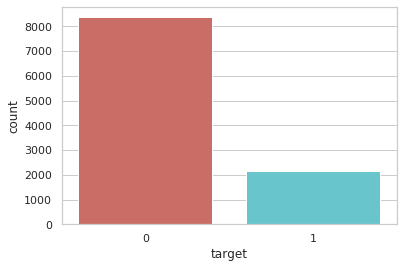

<Figure size 432x288 with 0 Axes>

In [26]:
sns.countplot(x='target',data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

Let's get a sense of the numbers across the two classes

In [27]:
data.groupby('target').mean()

,household_key,zip5,length_of_residence
target,,,
0,1.499780e+07,2962.866276,6.841181
1,1.583735e+07,2901.525802,8.649000


We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [28]:
data.groupby('income').mean()

,household_key,zip5,length_of_residence,target
income,,,,
0,1.629914e+07,3025.096182,0.032474,0.139812
"10-19,999",1.422413e+07,2895.827988,9.743440,0.311953
"100-149,999",1.415988e+07,2907.156863,12.225490,0.224790
"150 - 174,999",2.040161e+07,2909.629167,13.220833,0.216667
"175 - 199,999",1.446594e+07,2906.204611,11.536023,0.198847
"20-29,999",1.729301e+07,2921.746544,11.668203,0.225806
"200 - 249,999",1.766330e+07,2865.625551,11.246696,0.180617
250K+,1.844213e+07,2984.306977,11.958140,0.144186
"30-39,999",1.245112e+07,2901.684982,11.395604,0.285714


In [29]:
data.groupby('sc_vehicle_manufacturer_name').mean()

,household_key,zip5,length_of_residence,target
sc_vehicle_manufacturer_name,,,,
ACURA,1.595214e+07,2949.396226,6.735849,0.301887
APRILIA,3.752326e+07,2910.000000,9.000000,1.000000
AUDI,2.175704e+07,2880.000000,7.142857,0.214286
AUSTIN HEALEY,6.232293e+07,2919.000000,0.000000,0.000000
BICYCLE,9.163999e+06,2901.500000,1.500000,0.500000
...,...,...,...,...
Unknown,1.491864e+07,2995.790079,5.600527,0.169902
VOLKSWAGEN,1.509558e+07,2906.768182,8.622727,0.254545
VOLKSWAGON,5.726121e+06,2920.000000,15.000000,1.000000


In [30]:
data.groupby('motorcycle_indicator').mean()

,household_key,zip5,length_of_residence,target
motorcycle_indicator,,,,
N,1.487662e+07,2961.655734,6.734772,0.190629
Y,1.615542e+07,2912.170610,8.813616,0.251142


Visualizations

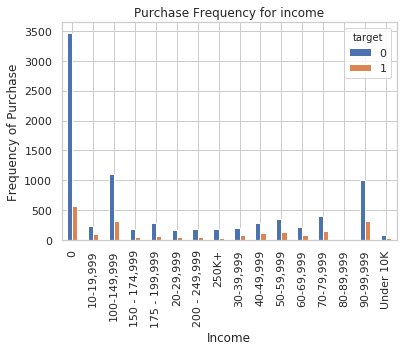

In [32]:
%matplotlib inline
pd.crosstab(data.income,data.target).plot(kind='bar')
plt.title('Purchase Frequency for income')
plt.xlabel('Income')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_income')

The frequency of purchase of the product depends a great deal on the income. Thus, the income can be a good predictor of the outcome variable.

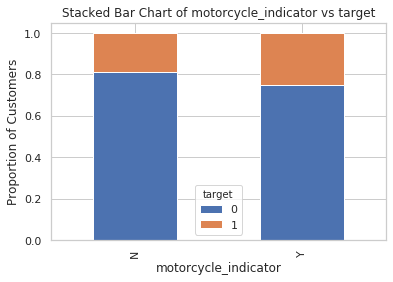

In [33]:
table=pd.crosstab(data.motorcycle_indicator,data.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of motorcycle_indicator vs target')
plt.xlabel('motorcycle_indicator')
plt.ylabel('Proportion of Customers')
plt.savefig('motorcycle_indicator_vs_pur_stack')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

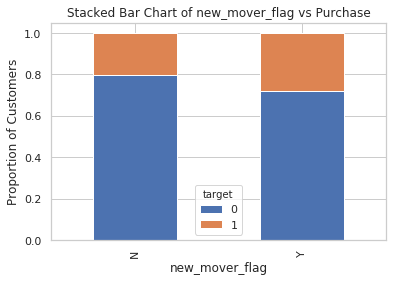

In [34]:
table=pd.crosstab(data.new_mover_flag,data.target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of new_mover_flag vs Purchase')
plt.xlabel('new_mover_flag')
plt.ylabel('Proportion of Customers')
plt.savefig('new_mover_flag_vs_pur_stack')

new_mover_flag seems a good predictor of the outcome variable.

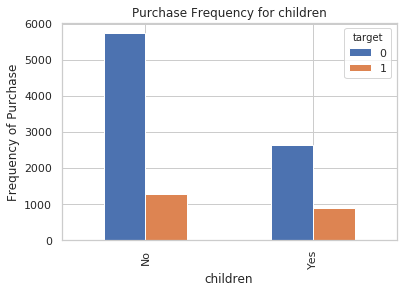

In [35]:
pd.crosstab(data.children,data.target).plot(kind='bar')
plt.title('Purchase Frequency for children')
plt.xlabel('children')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_children_bar')

Month might be a good predictor of the outcome variable

The most of the customers of the bank in this dataset are in the age range of 30-40.

### Create dummy variables

In [0]:
cat_vars=['income', 'children', 'mosaic_household', 'mosaic_global_household', 'kcl_b_ind_mosaicsgrouping', 'new_mover_flag', 'motorcycle_indicator', 'sc_vehicle_manufacturer_name', 'sc_vehicle_model_name']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [0]:
cat_vars=['income', 'children', 'mosaic_household', 'mosaic_global_household', 'kcl_b_ind_mosaicsgrouping', 'new_mover_flag', 'motorcycle_indicator', 'sc_vehicle_manufacturer_name', 'sc_vehicle_model_name']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [38]:
data_final=data[to_keep]
data_final.columns.values

array(['household_key', 'zip5', 'length_of_residence', 'target',
       'income_0', 'income_10-19,999', 'income_100-149,999',
       'income_150 - 174,999', 'income_175 - 199,999', 'income_20-29,999',
       'income_200 - 249,999', 'income_250K+', 'income_30-39,999',
       'income_40-49,999', 'income_50-59,999', 'income_60-69,999',
       'income_70-79,999', 'income_80-89,999', 'income_90-99,999',
       'income_Under 10K', 'children_No', 'children_Yes',
       'mosaic_household_Aging in Place',
       'mosaic_household_Aging of Aquarius',
       'mosaic_household_American Royalty',
       'mosaic_household_Babies and Bliss',
       'mosaic_household_Balance and Harmony',
       'mosaic_household_Birkenstocks and Beemers',
       'mosaic_household_Blue Collar Comfort',
       'mosaic_household_Bohemian Groove',
       'mosaic_household_Boomers and Boomerangs',
       'mosaic_household_Booming and Consuming',
       'mosaic_household_Colleges and Cafes',
       'mosaic_household_Cosmop

In [0]:

X = data_final.loc[:, data_final.columns != 'target']
y = data_final.loc[:, data_final.columns == 'target']

In [40]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['target']==0]))
print("Number of subscription",len(os_data_y[os_data_y['target']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['target']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['target']==1])/len(os_data_X))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  11726
Number of no subscription in oversampled data 5863
Number of subscription 5863
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [0]:
data_final_vars=data_final.columns.values.tolist()
y=['target']
X=[i for i in data_final_vars if i not in y]

In [43]:
# from sklearn import datasets
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(solver='lbfgs')

# rfe = RFE(logreg, 20)
# rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

[ True  True  True  True False  True False False False False False False
 False False False False False False False  True False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False  True False  True False False False False False
 False False  True False  True False  True False False False False False
 False False False False False False False False False  True False  True
 False  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [0]:
# data_final_vars=data_final.columns.values.tolist()
# y=['ins_client_flag_Y']
# X=[i for i in data_final_vars if i not in y]

### Feature Selection

In [0]:
# from sklearn import datasets
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression()

# rfe = RFE(logreg, 18)
# rfe = rfe.fit(data_final[X], data_final[y] )
# print(rfe.support_)
# print(rfe.ranking_)
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
#################### OUTPUT ############
# 'zip5',
# 'length_of_residence',
# 'income_100-149,999',
# 'children_No',
# 'mosaic_household_AginginPlace',
# 'mosaic_global_household_BourgeoisProsperity',
# 'mosaic_global_household_ComfortableRetirement',
# 'kcl_b_ind_mosaicsgrouping_AutumnYears',
# 'kcl_b_ind_mosaicsgrouping_BoomingwithConfidence',
# 'new_mover_flag_N',
# 'new_mover_flag_Y',
# 'motorcycle_indicator_N',
# 'motorcycle_indicator_Y',
# 'sc_vehicle_manufacturer_name_TOYOTA',


In [0]:
cols=['zip5',
'length_of_residence',
'income_100-149,999',
'children_No',
'mosaic_household_Aging in Place',
'mosaic_global_household_Bourgeois Prosperity',
'mosaic_global_household_Comfortable Retirement',
'kcl_b_ind_mosaicsgrouping_Autumn Years',
'kcl_b_ind_mosaicsgrouping_Booming with Confidence',
'new_mover_flag_N',
'new_mover_flag_Y',
'motorcycle_indicator_N',
'motorcycle_indicator_Y',
'sc_vehicle_manufacturer_name_TOYOTA'
] 
X=data_final[cols]
y=data_final['target']

### Implementing the model

In [59]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.496160
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                10519
Model:                          Logit   Df Residuals:                    10506
Method:                           MLE   Df Model:                           12
Date:                Tue, 17 Dec 2019   Pseudo R-squ.:                 0.02053
Time:                        16:22:08   Log-Likelihood:                -5219.1
converged:                       True   LL-Null:                       -5328.5
Covariance Type:            nonrobust   LLR p-value:                 4.196e-40
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
zip5                          

The p-values for most of the variables are very small, therefore, most of them are significant to the model.

Optimization based on removing higer P values

In [60]:
cols=['zip5',
'length_of_residence',
'children_No',
'mosaic_global_household_Bourgeois Prosperity'
] 
X=data_final[cols]
y=data_final['target']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.498458
         Iterations 6
                                       Results: Logit
Model:                        Logit                     Pseudo R-squared:          0.016     
Dependent Variable:           target                    AIC:                       10494.5601
Date:                         2019-12-17 16:28          BIC:                       10523.6038
No. Observations:             10519                     Log-Likelihood:            -5243.3   
Df Model:                     3                         LL-Null:                   -5328.5   
Df Residuals:                 10515                     LLR p-value:               1.0145e-36
Converged:                    1.0000                    Scale:                     1.0000    
No. Iterations:               6.0000                                                         
--------------------------------------------------------------------------------------------

### Logistic Regression Model Fitting

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Predicting the test set results and caculating the accuracy

In [0]:
y_pred = logreg.predict(X_test)

In [63]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


### Cross Validation

In [66]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(solver="lbfgs")
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.796


### Confusion Matrix

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2505    0]
 [ 651    0]]


The result is telling us that we have 2505 correct predictions and 651 incorrect predictions.

#### Accuracy

In [70]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


#### Compute precision, recall, F-measure and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89      2505
           1       0.00      0.00      0.00       651

    accuracy                           0.79      3156
   macro avg       0.40      0.50      0.44      3156
weighted avg       0.63      0.79      0.70      3156



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Interpretation: 

Of the entire test set, 88% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 90% of the customer's preferred term deposit were promoted.

### ROC Curvefrom sklearn import metrics
from ggplot import *

prob = clf1.predict_proba(X_test)[:,1]
fpr, sensitivity, _ = metrics.roc_curve(Y_test, prob)

df = pd.DataFrame(dict(fpr=fpr, sensitivity=sensitivity))
ggplot(df, aes(x='fpr', y='sensitivity')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

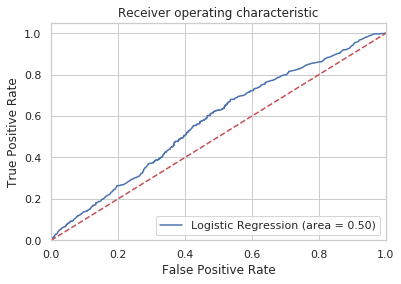

In [72]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()